0. Check Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import numpy as np
import matplotlib.pyplot as plt
import pickle

1. Define Environment

In [3]:
class Canvas(object):
  def __init__(self, adjacency_matrix:list, cells:dict, macro_indices:list, std_indices:list, canvas_size:int, reward_weights:list):

    self.canvas_size = canvas_size
    self.adjacency_matrix = adjacency_matrix
    self.cell_num = len(cells)
    self.cells = cells
    self.macro_indices = macro_indices
    self.std_indices = std_indices
    self.reward_weights = np.array(reward_weights)

    self.canvas = np.array([[-1 for i in range(self.canvas_size)] for j in range(self.canvas_size)])
    self.density_grid = np.array([[0 for i in range(self.canvas_size-1)] for j in range(self.canvas_size-1)])
    self.cell_place = np.array([[-1,-1] for cell in range(self.cell_num)])  

    self.macro_idx_in_macro_array = 0
    self.static_features = self.get_static_features()

    self.color_list = [np.random.randint(256, size=3) for i in range(self.cell_num+2)]
    self.color_list[0] = [255,255,255]

  def reset(self):
    self.canvas = np.array([[-1 for i in range(self.canvas_size)] for j in range(self.canvas_size)])
    self.density_grid = np.array([[0 for i in range(self.canvas_size-1)] for j in range(self.canvas_size-1)])
    self.cell_place = np.array([[-1,-1] for cell in range(self.cell_num)])  
    self.macro_idx_in_macro_array = 0
    return self.get_all_features()

  def place_macro(self, node_idx:int, action:list):

    for y in range(action[0]-int(self.cells[node_idx]['height']-1)//2, action[0]+int(self.cells[node_idx]['height'])//2+1):
      for x in range(action[1]-int(self.cells[node_idx]['width']-1)//2,action[1]+int(self.cells[node_idx]['width'])//2+1):
        try:
          self.canvas[y][x] = node_idx
        except IndexError:
          pass
        try:
          if y>0 and x>0:
            self.density_grid[y-1][x-1] += 1
        except IndexError:
          pass
        try:
          if y>0:
            self.density_grid[y-1][x] += 1
        except IndexError:
          pass
        try:
          if x>0:
            self.density_grid[y][x-1] += 1
        except IndexError:
          pass
        try:
          self.density_grid[y][x] += 1
        except IndexError:
          pass

    self.canvas[action[0]][action[1]] = node_idx
    self.cell_place[node_idx] = action

    return

  def place_std(self):
    for std in self.std_indices:
      canvas = self.get_node_mask(std)
      flag = 0
      for i in range(self.canvas_size):
        for j in range(self.canvas_size):
          if flag == 1:
            break
          for j in range(self.canvas_size):
            if canvas[i][j] == 1:
              self.place_macro(std, [i,j])
              flag = 1
              break
    return

  def get_static_features(self):
    features = []
    features.append(len(self.macro_indices))

    for i in range(self.cell_num):
      if i in self.macro_indices:
        features.append(1)
      else:
        features.append(0)
    
    for i in self.adjacency_matrix:
      for j in i:
        features.append(j)

      features.append(self.canvas_size)

      return features

  def get_dynamic_features(self):
    features = []
    features.append(self.macro_indices[self.macro_idx_in_macro_array])
    for i in self.canvas:
      for j in i:
        features.append(j)

    return features

  def get_all_features(self):
    static_features = self.static_features
    dynamic_features = self.get_dynamic_features()

    return np.array(static_features + dynamic_features)

  def get_node_mask(self, node_idx:int):

    mask = np.array([[1 if i==-1 else 0 for i in j] for j in self.canvas])

    # #find occupied site from the canvas and do not place near there
    # occupied = np.where(self.canvas!=-1)
    # s = len(occupied[0])
    # for i in range(s):
    #   mask[max(0, occupied[0][i]-int(self.cells[node_idx]['height'])//2):min(self.canvas_size,occupied[0][i]+int(self.cells[node_idx]['height']+1)//2),max(0, occupied[1][i]-int(self.cells[node_idx]['width'])//2):min(self.canvas_size,occupied[1][i]+int(self.cells[node_idx]['width']+1)//2)] = 0

    #cannot place near edges
    mask[0:int(self.cells[node_idx]['height']-1)//2,0:self.canvas_size] = 0
    mask[self.canvas_size-1-int(self.cells[node_idx]['height']-1)//2: self.canvas_size,0:self.canvas_size] = 0
    mask[0:self.canvas_size,0:int(self.cells[node_idx]['width']-1)//2] = 0
    mask[0:self.canvas_size,self.canvas_size-1-int(self.cells[node_idx]['width']-1)//2: self.canvas_size] = 0

    #density constraint
    dense = np.where(self.density_grid>=2)
    s = len(dense[0])
    for x in range(s):
     i = dense[0][x]
     j = dense[1][x]
     mask[max(0, i-int(self.cells[node_idx]['height'])//2-1):min(self.canvas_size,i+int(self.cells[node_idx]['height']+1)//2+1), max(0, j-int(self.cells[node_idx]['width'])//2-1):min(self.canvas_size,j+int(self.cells[node_idx]['width']+1)//2+1)] = 0


    return mask

  def get_reward(self):

    cost = np.array([self.get_wirelength(), self.get_congestion(), self.get_density()])
    
    return -1*np.dot(self.reward_weights, cost)    

  def get_wirelength(self):

    wirelength = 0
    for i in range(len(self.adjacency_matrix)):
      if self.cell_place[i][0] == -1 and self.cell_place[i][1] == -1:
        continue
      for j in range(i,len(self.adjacency_matrix[0])):
        if self.cell_place[j][0] == -1 and self.cell_place[j][1] == -1:
          continue
        if self.adjacency_matrix[i][j] >0 and i != j:
          wirelength += abs(self.cell_place[i][0]-self.cell_place[j][0])+abs(self.cell_place[i][1]-self.cell_place[j][1])+2
    return wirelength

  def get_congestion(self):

    routing_grid = np.array([[0 for i in range(self.canvas_size-1)] for j in range(self.canvas_size-1)])

    for cell1 in range(self.cell_num):
      connected = np.where(np.array(self.adjacency_matrix[cell1])!=0)[0]

      for cell2 in connected:
        if cell2 <= cell1:
          continue
        routing_type = np.random.randint(2)
        position_type = (self.cell_place[cell1][1]<=self.cell_place[cell2][1]) + (self.cell_place[cell1][0]<=self.cell_place[cell2][0])
        x1 = min(self.cell_place[cell1][1], self.cell_place[cell2][1])
        x2 = max(self.cell_place[cell1][1], self.cell_place[cell2][1])
        y1 = min(self.cell_place[cell1][0], self.cell_place[cell2][0])
        y2 = max(self.cell_place[cell1][0], self.cell_place[cell2][0])
        if routing_type%2 == 0:
          routing_grid[y1, x1:x2] += 1
          if (routing_type+position_type)%2==0:
            routing_grid[y1:y2, x2] += 1
          else:
            routing_grid[y1:y2, x1] += 1
        else:
          routing_grid[y2, x1:x2] += 1
          if (routing_type+position_type)%2==0:
            routing_grid[y1:y2, x2] += 1
          else:
            routing_grid[y1:y2, x1] += 1

    congestion = np.max(routing_grid)

    return congestion

  def get_density(self):
    density = 0
    return density

  def show_chip_canvas(self, mode, path):
    image = np.array([[self.color_list[self.canvas[j//8][i//8]+1] for i in range(8*self.canvas_size)] for j in range(8*self.canvas_size)])
    for i in range(self.cell_num):
      for j in range(i+1, self.cell_num):
        y = [8*self.cell_place[i][0]+3, 8*self.cell_place[j][0]+3]
        x = [8*self.cell_place[i][1]+3, 8*self.cell_place[j][1]+3]
        # plt.plot(x, y, color="red", linewidth=0.4, alpha=0.7)
    # if mode=="show":
    #   plt.text(50,270,"HPWL: "+str(self.get_wirelength()), size="xx-large")
    #   plt.text(50,285,"Congestion: "+str(self.get_congestion()), size="xx-large")
    #   plt.text(50,300,"Reward: "+str(self.get_reward()), size="xx-large")
    plt.text(50,270,"HPWL: "+str(self.get_wirelength()), size="xx-large")
    plt.text(50,285,"Congestion: "+str(self.get_congestion()), size="xx-large")
    plt.text(50,300,"Reward: "+str(self.get_reward()), size="xx-large")
    for i in range(self.canvas_size):
      plt.plot([0,8*32], [8*i-1,8*i-1],c = 'gray', linestyle = '--', linewidth=0.5)
    for j in range(self.canvas_size):
      plt.plot([8*j-1,8*j-1], [0,8*32], c = 'gray', linestyle = '--', linewidth=0.5)
    fig = plt.imshow(image)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if mode=="save":
      plt.savefig(path)

    return



In [4]:
class CircuitEnv(object):
  INFEASIBLE_REWARD = -1e5

  def __init__(self, adjacency_matrix, cells, macro_indices, std_indices, canvas_size=32, reward_weights=[1,0,0]):

    self.cells = cells
    self.macro_indices = macro_indices
    self.std_indices = std_indices
    self.adjacency_matrix = adjacency_matrix
    self.canvas_size = canvas_size
    self.reward_weights = reward_weights

    self.canvas = Canvas(adjacency_matrix, cells, macro_indices, std_indices, canvas_size, reward_weights)

    self.macro_idx_in_macro_array = 0
    self.macro_num = len(macro_indices)
    self.done = False
    self.action_history = []

    self.action_spec = canvas_size ** 2
    self.observation_spec = len(self.canvas.get_all_features())

  def reset(self):
    self.action_history = []
    self.done = False
    self.macro_idx_in_macro_array = 0
    return self.canvas.reset()

  def step(self, actions):
    
    if self.done:
      raise RuntimeError("Action taken after episode is done")

    macro_to_place = self.canvas.macro_indices[self.macro_idx_in_macro_array]

    mask = self.canvas.get_node_mask(macro_to_place)

    actions = actions.detach().numpy()
    actions = actions * mask

    info = {}
    if not self.done and not np.any(actions):
      info = {
          'wirelength': -1.0,
          'congestion': -1.0,
          'density': -1.0
      }
      return self.reset(), self.INFEASIBLE_REWARD, True, info
    

    action = np.argmax(actions)
    self.action_history.append(action)
    action = [action//self.canvas_size, action%self.canvas_size]

    self.canvas.place_macro(macro_to_place, action)
    features = self.canvas.get_all_features()
    self.macro_idx_in_macro_array += 1
    self.canvas.macro_idx_in_macro_array += 1

    
    if self.macro_idx_in_macro_array == self.macro_num:
      self.done = True
    if not self.done:
      reward = 0
    else:
      self.canvas.place_std()
      reward = self.canvas.get_reward()
      #features = self.reset()


    return features, reward, self.done, info

  def render(self, mode="show", path=""):
    self.canvas.show_chip_canvas(mode, path)
    return


2. Define Agent

In [5]:
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout = 0.5):
        super().__init__()

        #Build Actor Network (=PolicyNet)
        #PolicyNet gets canvas features as input and return probability distribution for each canvas spot
        #Please implement same as the original research
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 32)
        self.deconv_1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.deconv_2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.deconv_3 = nn.ConvTranspose2d(8, 4, 2, stride=2)
        self.deconv_4 = nn.ConvTranspose2d(4, 2, 2, stride=2)
        self.deconv_5 = nn.ConvTranspose2d(2, 1, 2, stride=2)


    def forward(self, x):
        #print(x.size())
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = torch.reshape(x, (32,1,1))
        x = self.deconv_1(x)
        x = F.relu(x)
        x = self.deconv_2(x)
        x = F.relu(x)
        x = self.deconv_3(x)
        x = F.relu(x)
        x = self.deconv_4(x)
        x = F.relu(x)
        x = self.deconv_5(x)
        x = F.relu(x)
        return x

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, output_dim=1, dropout = 0.5):
        super().__init__()

        #Build Actor Network (=Valuenet)
        #ValueNet gets canvas features as input and return value of the state
        #Error btw value and reward will be used to optimize PolicyNet
        #Please implement same as the original research
        self.fc = nn.Linear(input_dim, output_dim)
        #self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = self.fc(x)
        #x = self.dropout(x)
        x = F.relu(x)
        return x

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

3. Parse Data

In [8]:

with open("./netlist/adjacency_matrix", "rb") as f:
    adjacency_matrix = pickle.load(f)

with open("./netlist/cells", "rb") as f:
    cells = pickle.load(f)

with open("./netlist/macro_indices", "rb") as f:
    macro_indices = pickle.load(f)

with open("./netlist/std_indices", "rb") as f:
    std_indices = pickle.load(f)

In [9]:
test_macros = {}
test_stds = {}
for macro in macro_indices:
    test_macros[macro] = {'width':6, 'height':3}
    #test_macros[macro] = {'width':16, 'height':5}
for std in std_indices:
    test_stds[std] = {'width':3, 'height':3}
    #test_stds[std] = {'width':6, 'height':5}

test_cells = test_macros | test_stds

# for std in std_indices:
#    macro_indices.append(std)
# std_indices = []

# for macro in macro_indices:
#     test_macros[macro] = {'width':1, 'height':1}
# for std in std_indices:
#     test_stds[std] = {'width':1, 'height':1}

4. Start Learning

In [10]:
#utils
#You need basic knowledges about Reinforcement Learning
#Refer to https://github.com/bentrevett/pytorch-rl/blob/master/5%20-%20Proximal%20Policy%20Optimization%20(PPO)%20%5BCartPole%5D.ipynb
def calculate_returns(rewards, discount, normalize=True):
    
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R*discount
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values

    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):

    total_policy_loss = 0
    total_value_loss = 0

    advantages = advantages.detach()
    log_prob_actions = log_prob_actions.detach()
    actions = actions.detach()

    for _ in range(ppo_steps):

        action_pred = torch.tensor([])
        value_pred = torch.tensor([])

        for i in range(len(states)):
            a, v = policy(states[i])
            action_pred = torch.cat((action_pred, a))
            value_pred = torch.cat((value_pred, v))
        #action_pred, value_pred = policy(states)
        #value_pred = value_pred.squeeze(-1)

        action_prob = F.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)

        new_log_prob_actions = dist.log_prob(actions)

        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()

        #print(policy_ratio.size(), advantages.size())

        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        #action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action_prob[0])

        episode_reward += reward
        
    return episode_reward

In [11]:
def train(env, policy, optimizer, discount, ppo_steps, ppo_clip):
    
    policy.train()
    
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        states.append(state)

        action_pred, value_pred = policy(state)

        action_prob = F.softmax(action_pred, dim=-1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        #print(action_prob[0].size())

        #print(action)

        state, reward, done, _ = env.step(action_prob[0])

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount)
    advantages = calculate_advantages(returns, values)

    if len(advantages) != env.canvas.canvas_size:
        advantages = torch.cat((advantages, torch.tensor([-2*env.canvas.canvas_size**2 for i in range(env.canvas.canvas_size-len(advantages))])))
    
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [12]:
train_env = CircuitEnv(adjacency_matrix, test_cells, macro_indices, std_indices)
test_env = CircuitEnv(adjacency_matrix, test_cells, macro_indices, std_indices)
SEED = 100
np.random.seed(SEED)
torch.manual_seed(SEED)

In [13]:
INPUT_DIM = train_env.observation_spec
OUTPUT_DIM = train_env.action_spec

actor = Actor(INPUT_DIM)
critic = Critic(INPUT_DIM, 1)

policy = ActorCritic(actor, critic)

In [14]:
policy.apply(init_weights)

ActorCritic(
  (actor): Actor(
    (fc_1): Linear(in_features=1043, out_features=64, bias=True)
    (fc_2): Linear(in_features=64, out_features=32, bias=True)
    (deconv_1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (deconv_2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (deconv_3): ConvTranspose2d(8, 4, kernel_size=(2, 2), stride=(2, 2))
    (deconv_4): ConvTranspose2d(4, 2, kernel_size=(2, 2), stride=(2, 2))
    (deconv_5): ConvTranspose2d(2, 1, kernel_size=(2, 2), stride=(2, 2))
  )
  (critic): Critic(
    (fc): Linear(in_features=1043, out_features=1, bias=True)
  )
)

In [15]:
def place(env, policy, path):
    
    policy.eval()
    
    rewards = []
    done = False

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        #action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action_prob[0])

        rewards.append(reward)

    env.render(mode="save", path=path)
        
    return rewards

-312


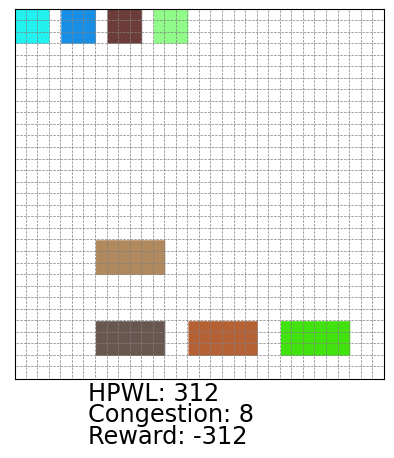

In [16]:
env = CircuitEnv(adjacency_matrix, test_cells, macro_indices, std_indices)
rewards = place(env, policy, "initial")
print(rewards[-1])

In [17]:
#This requires long time
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

MAX_EPISODES = 3000
DISCOUNT_FACTOR = 0.9999
N_TRIALS = 25
REWARD_THRESHOLD = -200
PRINT_EVERY = 100
PPO_STEPS = 1
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []


for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode == 1:
        print(f'| Episode: {episode:4} | Initial Train Reward: {train_reward:5.1f} | Initial Test Reward: {test_reward:5.1f} |')

    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:4} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        test_env.render(mode="save", path="after_train")
        break

    # path = "./img/"+str(episode)+".png"
    # place(env, policy, path)
    

| Episode:    1 | Initial Train Reward: -312.0 | Initial Test Reward: -322.0 |
| Episode:  100 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  200 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  300 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  400 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  500 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  600 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  700 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  800 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode:  900 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode: 1000 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode: 1100 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode: 1200 | Mean Train Rewards: -242.0 | Mean Test Rewards: -242.0 |
| Episode: 1300 | Mea

-242


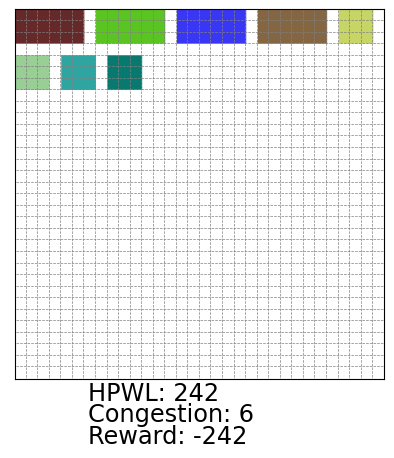

In [18]:
env = CircuitEnv(adjacency_matrix, test_cells, macro_indices, std_indices)
rewards = place(env, policy, "final")
print(rewards[-1])

In [19]:
env = CircuitEnv(adjacency_matrix, test_cells, macro_indices, std_indices)
state = env.reset()
state = torch.FloatTensor(state).unsqueeze(0)
print(policy(state)[0])

tensor([[[0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
         [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
         [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
         ...,
         [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
         [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
         [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550]]],
       grad_fn=<ReluBackward0>)


In [20]:
torch.save(policy, "placement_ispd18test3.pt")